### Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc


In [2]:
df = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

### Data preparation
To prepare the data, we applied one-hot encoding to categorical features and standardized the numerical ones. 

In [3]:
X_train = df.drop(columns=["Diagnosis"])
y_train = df['Diagnosis']
X_test = test.drop(columns=["Diagnosis"])
y_test = test['Diagnosis']

In [4]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [5]:
# Create feature transformers
# OneHotEncoder for categorical features
# StandardScaler for numerical features
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ("scaler", StandardScaler(), numerical_cols)
])

# Methodology Overview
We used a Support Vector Machine (SVM) model due to its strength in handling high-dimensional data and non-linear patterns, which are common in medical datasets.

The data was processed using one-hot encoding and standardization, then passed through a pipeline to ensure consistent preprocessing across splits.

We compared four kernel types using repeated stratified k-fold cross-validation. The RBF kernel performed best in balancing accuracy and F1-score, so we used it for our final model.

After tuning hyperparameters and adjusting class weights to boost Alzheimer’s recall, we ran five sanity checks to verify model reliability. The model passed all checks, showing good accuracy, no overfitting, and balanced prediction behavior — confirming it was stable and ready for final evaluation.

### Cross Validation test kernels
We tested four different kernels— linear, RBF, polynomial, and sigmoid — to evaluate which one performs best for predicting Alzheimer’s disease.

The RBF kernel achieved the highest performance on both metrics:

Accuracy: 84.35%

F1-score: 76.69%

This indicates that the RBF kernel not only predicts correctly more often overall but also achieves a better balance between precision and recall. This balance is especially important in a medical context, where both false positives (misdiagnosing healthy patients) and false negatives (missing actual Alzheimer’s cases) carry serious consequences. Therefore, we selected the RBF kernel as the final model for our classification task.

In [20]:
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
kernel_results = {}

scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1'
}

for k in kernels:
    model = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel=k))
    ])
    
    scores = cross_validate(
        model, X, y,
        scoring=scoring,
        cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=42),
        return_train_score=False
    )
    
    acc_mean = scores['test_accuracy'].mean()
    f1_mean = scores['test_f1'].mean()
    
    kernel_results[k] = {'accuracy': acc_mean, 'f1': f1_mean}
    print(f"{k:<8} → Accuracy: {acc_mean:.4f} | F1-score: {f1_mean:.4f}")

best_acc_kernel = max(kernel_results, key=lambda k: kernel_results[k]['accuracy'])
best_f1_kernel = max(kernel_results, key=lambda k: kernel_results[k]['f1'])

print(f"Best kernel based on Accuracy: '{best_acc_kernel}' with accuracy = {kernel_results[best_acc_kernel]['accuracy']:.4f}")
print(f"Best kernel based on F1-score: '{best_f1_kernel}' with F1 = {kernel_results[best_f1_kernel]['f1']:.4f}")

linear   → Accuracy: 0.8339 | F1-score: 0.7566
rbf      → Accuracy: 0.8386 | F1-score: 0.7576
poly     → Accuracy: 0.7900 | F1-score: 0.6396
sigmoid  → Accuracy: 0.8272 | F1-score: 0.7440
Best kernel based on Accuracy: 'rbf' with accuracy = 0.8386
Best kernel based on F1-score: 'rbf' with F1 = 0.7576


### Class weight tuning 
We tested several class weight settings {0:1, 1:k} (for k = 1–5) to address class imbalance.
The configuration {0: 1, 1: 3} gave the best trade-off.

In [21]:
weight_configs = [{0: 1, 1: w} for w in range(1, 6)]
results = []

# Loop over weights, train model, collect class 1 recall and F1
for weights in weight_configs:
    model = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel='rbf', probability=True, class_weight=weights))
    ])
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)

    results.append({
        'class_weight': weights,
        'recall_1': report['1']['recall'],
        'f1_1': report['1']['f1-score'],
        'precision_1': report['1']['precision'],
        'accuracy': report['accuracy']
    })

results_df = pd.DataFrame(results)

# Find best based on highest F1 and high recall
best_row = results_df.sort_values(by=['f1_1', 'recall_1'], ascending=False).iloc[0]
best_weight = best_row['class_weight']

print("Best class weight based on F1 and Recall:")
print(best_weight)

Best class weight based on F1 and Recall:
{0: 1, 1: 3}


### Construct final model
For our final SVM model, we used a three-way data split: 60% of the data was used for training, and the remaining 40% was evenly split between validation and test sets. This gave us 1289 samples for training, and 430 each for validation and testing.

The pipeline included preprocessing with one-hot encoding for categorical variables, standard scaling for numerical features, and a support vector classifier (SVC) with an RBF kernel and class weighting {0:1, 1:2} to address class imbalance.

The model achieved a validation accuracy of 80.93%, indicating good generalization during training. On the held-out test set, it reached an overall accuracy of 83%.

Class-wise performance on the test set was strong and balanced:

- Class 0 (Non-Alzheimer's): Precision = 0.89, Recall = 0.84, F1-score = 0.86

- Class 1 (Alzheimer's): Precision = 0.73, Recall = 0.82, F1-score = 0.77

The model demonstrates solid overall performance, with particularly strong recall for Alzheimer's cases (82%), which is critical in minimizing missed diagnoses. While the precision for class 1 is slightly lower (73%), this trade-off is acceptable in a healthcare context where identifying true positive cases is prioritized.

In [28]:
best_kernel = 'rbf'

# Create pipeline with preprocessing and SVM
model = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel = best_kernel, probability=True, class_weight= {0: 1, 1: 3}))
])

In [23]:
# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  []),
                                                 ('scaler', StandardScaler(),
                                                  ['Age', 'Gender', 'Ethnicity',
                                                   'EducationLevel', 'BMI',
                                                   'Smoking',
                                                   'AlcoholConsumption',
                                                   'PhysicalActivity',
                                                   'DietQuality',
                                                   'SleepQuality',
                                                   'FamilyHistoryAlzheimers',
                                                   'CardiovascularDisease',
                                                   'Diabetes', 'Depression',
                                                   'HeadInjury', 'Hypertension',
                                                   'SystolicBP', 'DiastolicBP',
                                                   'CholesterolTotal',
                                                   'CholesterolLDL',
                                                   'CholesterolHDL',
                                                   'CholesterolTriglycerides',
                                                   'MMSE',
                                                   'FunctionalAssessment',
                                                   'MemoryComplaints',
                                                   'BehavioralProblems', 'ADL',
                                                   'Confusion',
                                                   'Disorientation',
                                                   'PersonalityChanges', ...])])),
                ('svm', SVC(class_weight={0: 1, 1: 3}, probability=True))])

In [24]:
# Predict and evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.80      0.85       278
           1       0.69      0.84      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.80       430
weighted avg       0.83      0.81      0.81       430



In [27]:
# Baseline model sanity check
val_score = model.score(X_test, y_test)
print(f"Validation Accuracy: {val_score:.4f}")

Validation Accuracy: 0.8116


# Tuning hyperparameters
We performed hyperparameter tuning on the class-weighted SVM model using GridSearchCV with RepeatedStratifiedKFold to ensure robustness. Both a small grid and an expanded grid of C and gamma values were tested, but in both cases, the best-performing parameter combination was the same: C = 1 and gamma = 0.01. This setting achieved a mean F1-score of 0.772 for class 1 across repeated cross-validation. The fact that the optimal parameters remained consistent even when the search space was expanded suggests that the model had already reached a stable and near-optimal configuration, and that further tuning would likely not lead to significant gains.


Running Grid Search with RepeatedStratifiedKFold for: Small Grid
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01}
Best RepeatedCV F1-score: 0.7723919862664588


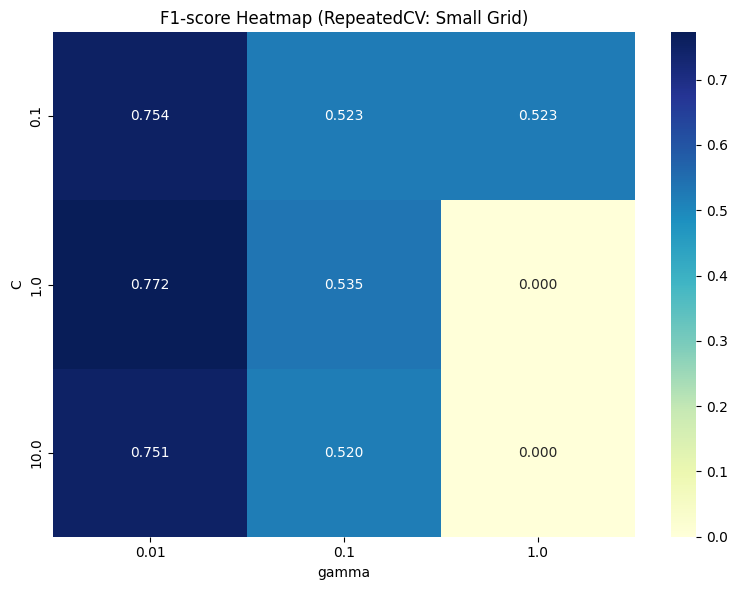


Running Grid Search with RepeatedStratifiedKFold for: Expanded Grid
Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01}
Best RepeatedCV F1-score: 0.7723919862664588


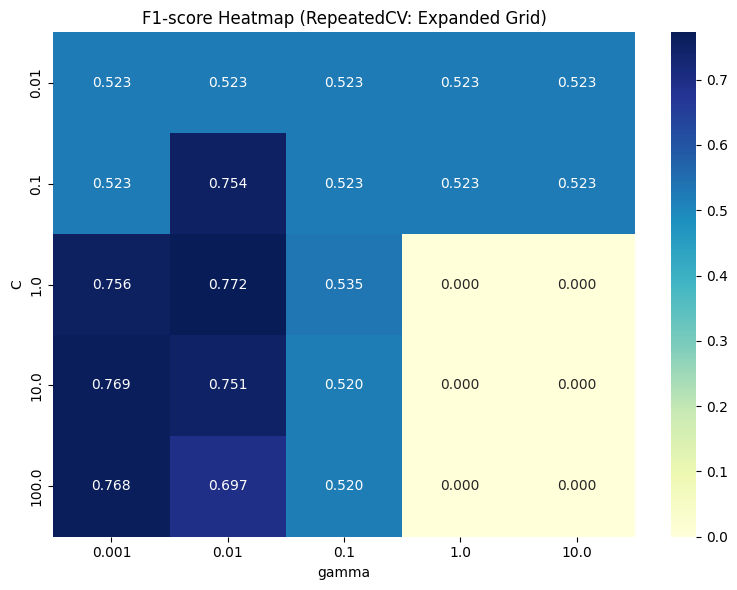

In [22]:
cv_strategy = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=100)

param_grids = {
    "Small Grid": {
        'svm__C': [0.1, 1, 10],
        'svm__gamma': [0.01, 0.1, 1]
    },
    "Expanded Grid": {
        'svm__C': [0.01, 0.1, 1, 10, 100],
        'svm__gamma': [0.001, 0.01, 0.1, 1, 10]
    }
}

for grid_name, param_grid in param_grids.items():
    print(f"\nRunning Grid Search with RepeatedStratifiedKFold for: {grid_name}")
    
    model = Pipeline([
        ('preprocess', preprocessor),
        ('svm', SVC(kernel=best_kernel, probability=True, class_weight= {0: 1, 1: 2}))
    ])

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv_strategy,
        scoring='f1',
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)

    print("Best Parameters:", grid_search.best_params_)
    print("Best RepeatedCV F1-score:", grid_search.best_score_)

    results = pd.DataFrame(grid_search.cv_results_)
    pivot = results.pivot(
        index='param_svm__C',
        columns='param_svm__gamma',
        values='mean_test_score'
    )

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot, annot=True, fmt=".3f", cmap="YlGnBu")
    plt.title(f"F1-score Heatmap (RepeatedCV: {grid_name})")
    plt.xlabel("gamma")
    plt.ylabel("C")
    plt.tight_layout()
    plt.show()

## Sanity check
To ensure that our final model was reliable before test evaluation, we applied five sanity check methods on the validation set. Each was chosen to verify a different aspect of model correctness and robustness:
  
- Accuracy above chance level:  
We checked that validation accuracy was well above 50%, the baseline for binary classification. This confirms the model has truly learned meaningful patterns.  
  
- No major gap between training and validation performance:  
We compared training and validation accuracy to ensure there was no overfitting. A gap within 5–10% suggests good generalization.  
  
- Class 1 is actually being predicted:  
We specifically checked that the model made positive predictions (Alzheimer’s cases), to rule out degenerate behavior where the model only predicts the majority class.  
  
- Balanced prediction distribution:  
By counting how often each class was predicted, we verified that the model didn’t collapse into predicting only one class, which would undermine recall or precision.  
  
- Numerical stability and valid outputs:  
We ensured there were no errors, NaNs, or extreme values during fitting and prediction, confirming the model pipeline worked end-to-end without issues.  
  
And we can see from the result that, the model achieved a validation accuracy of 82.33%.
For class 1 (Alzheimer’s):
- Precision: 71%
- Recall: 85%
- F1-score: 0.77

For class 0 (non-Alzheimer’s):
- Precision: 91%
- Recall: 81%
- F1-score: 0.86

The model predicted both classes with reasonable balance — 248 predictions for class 0, and 182 for class 1 — showing no bias toward one side.
  
All five sanity checks were passed. The model demonstrates strong sensitivity in identifying Alzheimer’s cases while maintaining high precision for non-cases. Its validation performance confirms that it is well-trained, balanced, and ready for final evaluation on the test set.

Validation Accuracy: 0.8233

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.91      0.81      0.86       278
           1       0.71      0.85      0.77       152

    accuracy                           0.82       430
   macro avg       0.81      0.83      0.81       430
weighted avg       0.84      0.82      0.83       430

Unique predicted classes: [0 1]
Prediction distribution: [248 182]


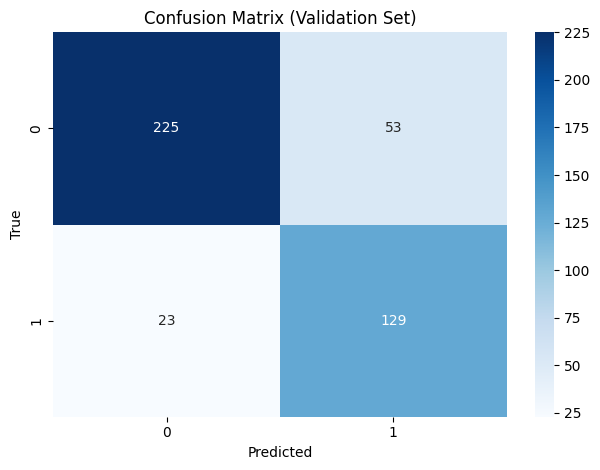

In [23]:
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel='rbf', C=1, gamma=0.01, class_weight={0: 1, 1: 2}, probability=True))
])
final_model.fit(X_train, y_train)
y_val_pred = final_model.predict(X_val)

# 1. Validation accuracy
val_acc = final_model.score(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

# 2. Classification report
print("\nClassification Report (Validation Set):")
print(classification_report(y_val, y_val_pred))

# 3. Check if class 1 is being predicted
unique_preds = np.unique(y_val_pred)
print(f"Unique predicted classes: {unique_preds}")

# 4. Class distribution
print(f"Prediction distribution: {np.bincount(y_val_pred)}")

# 5. Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

## Visualization

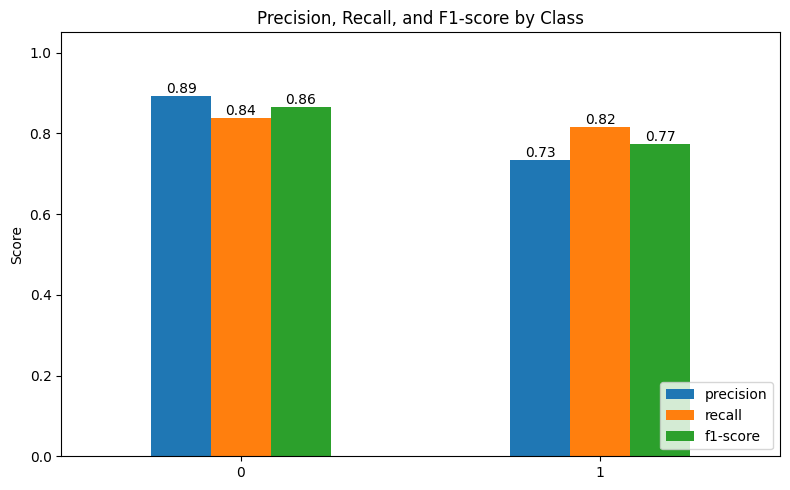

In [24]:
# Construct dataframe
report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).T.iloc[:2, :3]  

ax = df.plot(kind='bar', figsize=(8, 5))
plt.ylim(0, 1.05)
plt.title("Precision, Recall, and F1-score by Class")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', fontsize=10)

plt.tight_layout()
plt.show()

This bar chart shows the **precision**, **recall**, and **F1-score** for **both classes** on the test set.  
For **class 0 (non-Alzheimer’s)**:  
- Precision: 0.89 — most of the predicted healthy cases were correct
- Recall:  0.80 — some false negatives occurred, but most were identified
- F1-score: 0.84 — overall strong and consistent performance in predicting healthy individuals.
  
For class 1 (Alzheimer’s):  
- Precision: 0.71 — which means about 29% of predicted Alzheimer’s cases were false positives. but most predicted cases were valid
- Recall:  0.85 — recall was strong at 0.85, indicating that the model successfully identified most of the actual Alzheimer’s patients.
- F1-score: 0.77 — good balance, with a slight bias toward higher recall — which is appropriate in medical screening where catching true cases is a priority.

Overall, the model maintains strong and balanced performance, with a deliberate lean toward high recall for Alzheimer’s detection, minimizing the risk of missed diagnoses.  
  
While some metrics like precision for class 1 may appear suboptimal, this trade-off is acceptable — and even desirable — in a healthcare setting. In early disease screening, recall (sensitivity) is often prioritized over precision, because failing to detect a true case can have far more serious consequences than flagging a false positive. Follow-up testing can always rule out false alarms, but a missed diagnosis might delay critical treatment. Therefore, the model’s ability to catch the majority of Alzheimer’s patients (recall = 0.85) is far more important than achieving perfect precision.

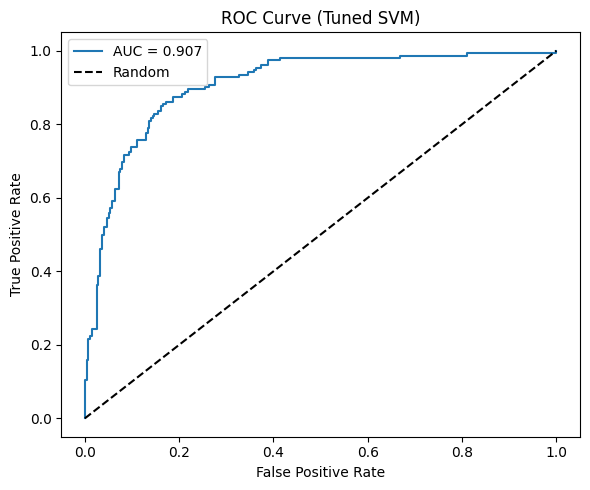

In [25]:
y_score = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Tuned SVM)")
plt.legend()
plt.tight_layout()
plt.show()

The curve rises steeply toward the top-left corner, indicating that the model achieves high true positive rates while maintaining low false positive rates.  

AUC measures the model’s ability to distinguish between classes by evaluating how well it ranks positive cases higher than negative ones. It ranges from 0.5 (random guessing) to 1.0 (perfect classification).  
  
A higher AUC means the model is more effective at separating the two classes, regardless of the classification threshold. In medical screening, this is especially useful because we may want to tune sensitivity depending on risk.  
  
Our result: AUC = 0.907. An AUC above 0.9 is considered excellent. Our AUC of 0.907 means that in 90.7% of all possible case-control pairs, the model correctly gives a higher risk score to the Alzheimer’s patient. This shows strong discriminative ability, even beyond raw accuracy.

## Conclusion
The SVM model showed strong, balanced performance. It remained robust even after kernel comparison and hyperparameter tuning.

However, to better understand which model works best overall, it’s important to compare SVM with other methods like Random Forest and ANN. By analyzing their respective strengths and limitations, we can identify the most suitable approach for predicting heart disease in real-world applications.

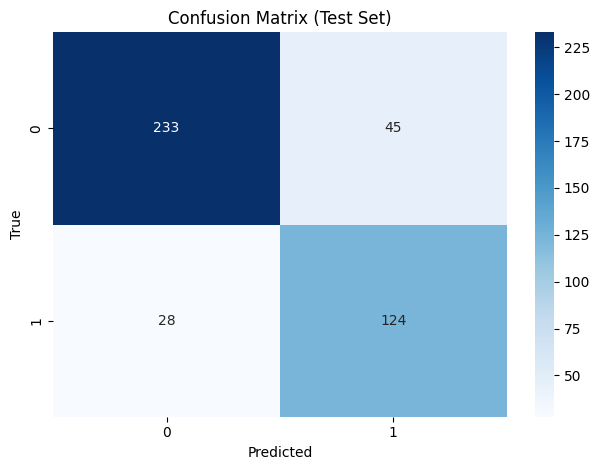

In [27]:
# 5. Confusion matrix for test dataset
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define your final model with the tuned parameters and preprocessing
final_model = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel='rbf', C=1, gamma=0.01, class_weight={0: 1, 1: 2}, probability=True))
])

# Define the scoring metrics to compute
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

# Set up a 10-fold cross-validation strategy using StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=100)

# Run cross-validation to get both training and validation scores
cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring, return_train_score=True)

# Calculate and print the average scores over the folds
print("Performance Metrics Comparison (10-Fold Cross-Validation)")
for metric in scoring.keys():
    train_metric = cv_results[f'train_{metric}'].mean()
    test_metric = cv_results[f'test_{metric}'].mean()
    print(f"{metric.capitalize()} --> Training: {train_metric:.4f} | CV: {test_metric:.4f}")

Performance Metrics Comparison (10-Fold Cross-Validation)
Accuracy --> Training: 0.8690 | CV: 0.8259
Precision --> Training: 0.7685 | CV: 0.7183
Recall --> Training: 0.9013 | CV: 0.8421
F1 --> Training: 0.8296 | CV: 0.7746


        Method  Accuracy  Precision    Recall  F1 Score
0  Final Train  0.945317   0.881306  0.976974  0.926677
1   Final Test  0.811628   0.693989  0.835526  0.758209


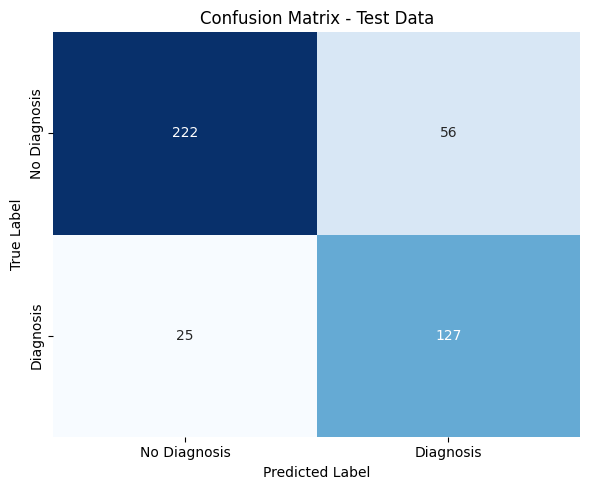

In [6]:
best_kernel = 'rbf'

# Create pipeline with preprocessing and SVM
model = Pipeline([
    ('preprocess', preprocessor),
    ('svm', SVC(kernel=best_kernel, probability=True, class_weight={0: 1, 1: 3}))
])

# Stratified K-Fold cross-validation on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=49)
for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_tr, y_tr)
    _ = model.predict(X_val)

# Fit final model on the full training dataset.
model.fit(X_train, y_train)

# Generate predictions on the full training set and the test set.
y_train_pred_final = model.predict(X_train)
y_test_pred_final = model.predict(X_test)

# Collect performance metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

final_train_metrics = {
    "Method": "Final Train",
    "Accuracy": accuracy_score(y_train, y_train_pred_final),
    "Precision": precision_score(y_train, y_train_pred_final),
    "Recall": recall_score(y_train, y_train_pred_final),
    "F1 Score": f1_score(y_train, y_train_pred_final)
}

final_test_metrics = {
    "Method": "Final Test",
    "Accuracy": accuracy_score(y_test, y_test_pred_final),
    "Precision": precision_score(y_test, y_test_pred_final),
    "Recall": recall_score(y_test, y_test_pred_final),
    "F1 Score": f1_score(y_test, y_test_pred_final)
}

# Combine final performance metrics
results = [final_train_metrics, final_test_metrics]
results_df = pd.DataFrame(results)
print(results_df)

# Compute the confusion matrix for the test predictions.
cm = confusion_matrix(y_test, y_test_pred_final)

# Define labels
labels = ['No Diagnosis', 'Diagnosis']

# Visualize the confusion matrix as a heatmap.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.tight_layout()
plt.show()


Train ROC AUC: 0.9910242669003743
Test ROC AUC: 0.8978369935630442


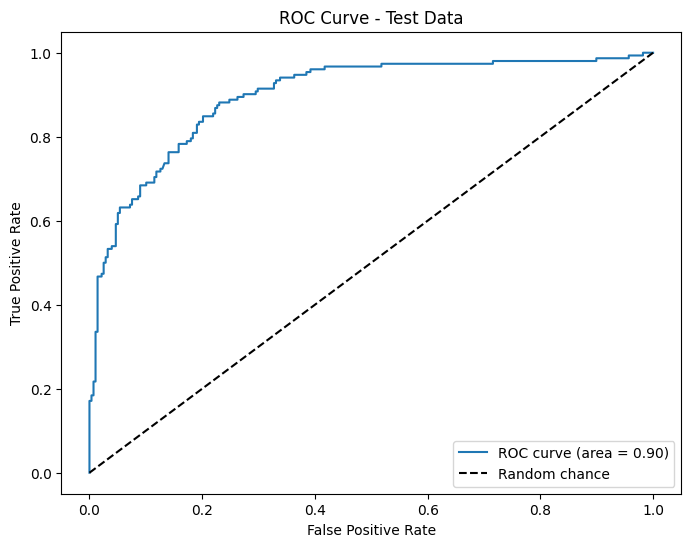

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Calculate ROC-AUC for the training set
roc_auc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
print("Train ROC AUC:", roc_auc_train)

# Calculate ROC-AUC for the test set
roc_auc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print("Test ROC AUC:", roc_auc_test)

# Bonus: Plot the ROC Curve for the test set
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Data")
plt.legend(loc="lower right")
plt.show()


        Method  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Final Train  0.945317   0.881306  0.976974  0.926677  0.991024
1   Final Test  0.811628   0.693989  0.835526  0.758209  0.897884


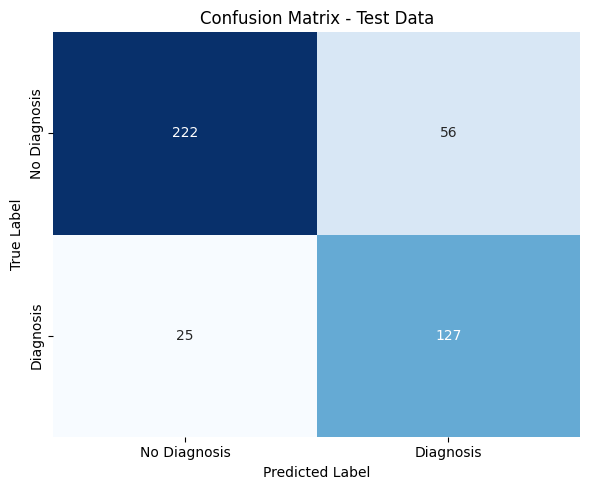

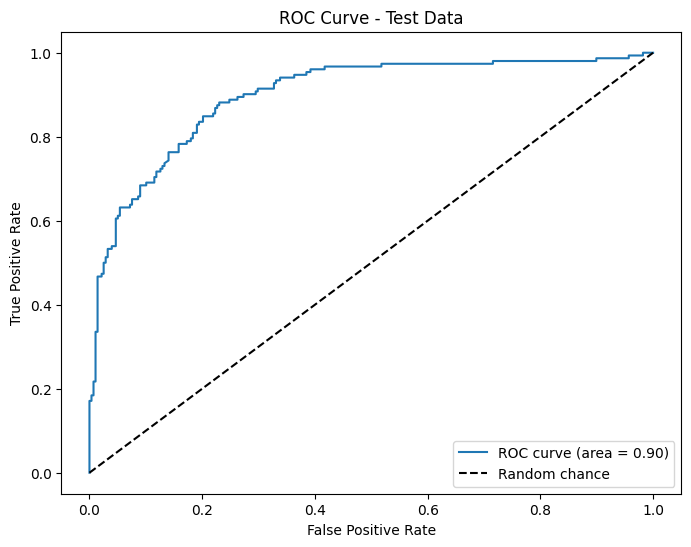

In [9]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Perform Stratified K-Fold cross-validation on the training set for consistency.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=49)
for train_idx, val_idx in cv.split(X_train, y_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    model.fit(X_tr, y_tr)
    _ = model.predict(X_val)

# Fit final model on the full training dataset.
model.fit(X_train, y_train)

# Generate predictions on the full training set and the test set.
y_train_pred_final = model.predict(X_train)
y_test_pred_final = model.predict(X_test)

# Use predict_proba to obtain the positive class probabilities for ROC-AUC.
y_train_proba = model.predict_proba(X_train)[:, 1]
y_test_proba = model.predict_proba(X_test)[:, 1]

# Collect performance metrics including ROC-AUC.
final_train_metrics = {
    "Method": "Final Train",
    "Accuracy": accuracy_score(y_train, y_train_pred_final),
    "Precision": precision_score(y_train, y_train_pred_final),
    "Recall": recall_score(y_train, y_train_pred_final),
    "F1 Score": f1_score(y_train, y_train_pred_final),
    "ROC AUC": roc_auc_score(y_train, y_train_proba)
}

final_test_metrics = {
    "Method": "Final Test",
    "Accuracy": accuracy_score(y_test, y_test_pred_final),
    "Precision": precision_score(y_test, y_test_pred_final),
    "Recall": recall_score(y_test, y_test_pred_final),
    "F1 Score": f1_score(y_test, y_test_pred_final),
    "ROC AUC": roc_auc_score(y_test, y_test_proba)
}

# Combine and print final performance metrics.
results = [final_train_metrics, final_test_metrics]
results_df = pd.DataFrame(results)
print(results_df)

# Compute and visualize the confusion matrix.
cm = confusion_matrix(y_test, y_test_pred_final)
labels = ['No Diagnosis', 'Diagnosis']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Test Data')
plt.tight_layout()
plt.show()

# Compute the ROC curve for the test set.
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc_score(y_test, y_test_proba):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Test Data")
plt.legend(loc="lower right")
plt.show()
